## 1)

In [4]:
import numpy as np
import pandas as pd

In [50]:
blob_data = pd.read_csv('blobs2.csv').values
blob_X = blob_data[:, :-1].astype('float64')
blob_y = blob_data[:, -1]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

In [10]:
from sklearn import svm


def plot_svm_classifier(title, **arguments):
    model = svm.SVC(**arguments)
    model.fit(blob_X, blob_y)
    
    h = 0.01
    x_min, x_max = blob_X[:, 0].min() - 1, blob_X[:, 0].max() + 1
    y_min, y_max = blob_X[:, 1].min() - 1, blob_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='viridis')
    plt.scatter(blob_X[:, 0], blob_X[:, 1], c=blob_y, s=50, cmap='viridis')
    plt.scatter(blob_X[:, 0][model.support_], blob_X[:, 1][model.support_],
                c=blob_y[model.support_], cmap='viridis', s=60, edgecolors='black')
    plt.title(title)
    plt.show()

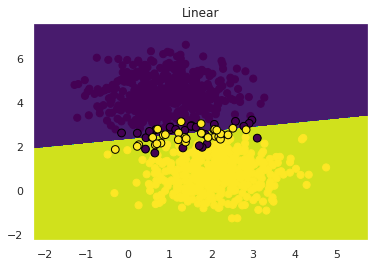

In [67]:
plot_svm_classifier(kernel='linear', gamma='auto', title='Linear')

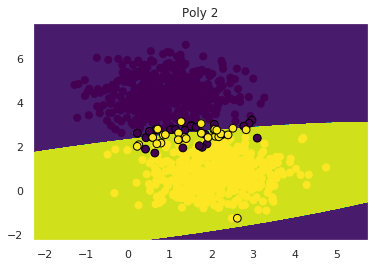

In [69]:
plot_svm_classifier(kernel='poly', degree=2, gamma='auto', title='Poly 2')

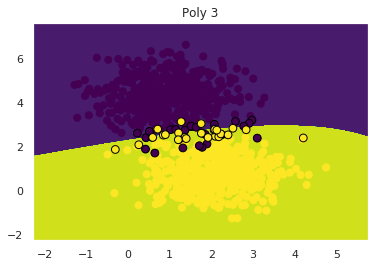

In [70]:
plot_svm_classifier(kernel='poly', degree=3, gamma='auto', title='Poly 3')

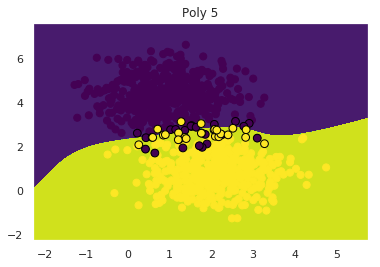

In [73]:
plot_svm_classifier(kernel='poly', degree=5, gamma='auto', title='Poly 5')

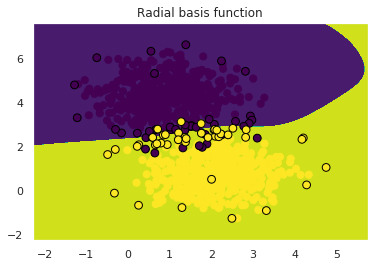

In [72]:
plot_svm_classifier(kernel='rbf', gamma='auto', title='Radial basis function')

## 2)

In [6]:
cancer_data = pd.read_csv('cancer.csv').values
spam_data = pd.read_csv('spam.csv').values

cancer_x = cancer_data[:, 1:]
cancer_y = cancer_data[:, 0]

spam_x = spam_data[:, :-1]
spam_y = spam_data[:, -1]

In [8]:
import time
from sklearn.ensemble import RandomForestClassifier

def get_fit_time(model):
    start = time.time()
    model.fit(X_train, y_train)
    return time.time() - start

def compare_forest_with_svm():
    svm_model = svm.SVC(kernel='linear', gamma='auto')
    forest_model = RandomForestClassifier(n_estimators=10, max_depth=5)
    forest_time, forest_score = get_fit_time(forest_model), forest_model.score(X_test, y_test)
    svm_time, svm_score = get_fit_time(svm_model), svm_model.score(X_test, y_test)
    print('Random forest time: ' + str(forest_time) + ', Random forest score: ' + str(forest_score))
    print('SVM time: ' + str(svm_time) + ', SVM score: ' + str(svm_score))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer_x, cancer_y, test_size=0.2, random_state=42)
print('Cancer:')
compare_forest_with_svm()

Cancer:
Random forest time: 0.07671689987182617, Random forest score: 0.9649122807017544
SVM time: 2.3924827575683594, SVM score: 0.956140350877193


In [81]:
X_train, X_test, y_train, y_test = train_test_split(spam_x, spam_y, test_size=0.2, random_state=42)
print('Spam:')
compare_forest_with_svm()

Spam:
Random forest time: 0.05574321746826172, Random forest score: 0.9153094462540716
SVM time: 371.74050092697144, SVM score: 0.9229098805646037


## 3)

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, title):
    lw = 2
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

In [13]:
from scipy.stats import norm

class GNBClassifier:
    def fit(self, X, y):
        self.labels, self.class_prob = np.unique(y, return_counts=True)
        self.class_prob = self.class_prob / len(y)
        self.calc_mean_and_std(X, y)
        
    def predict(self, X):
        prob = np.empty((X.shape[0], len(self.labels)))
        for label in range(len(self.labels)):
            pdfs = np.empty(X.shape)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    pdfs[i][j] = norm.pdf(X[i][j], loc=self.features_mean[label][j], scale=self.features_std[label][j])
            prob[:, label] = np.prod(pdfs, axis=1) * self.class_prob[label]
        for i in range(prob.shape[0]):
            if np.sum(prob[i]) != 0:
                prob[i] = prob[i] / np.sum(prob[i])
        return prob
    
    def calc_mean_and_std(self, X, y):
        self.features_mean = np.empty((len(self.labels), X.shape[1]))
        self.features_std = np.empty((len(self.labels), X.shape[1]))
        for label in range(len(self.labels)):
            self.features_mean[label] = np.mean(X[y == label, :], axis=0)
            self.features_std[label] = np.std(X[y == label, :], axis=0)

Roc auc score: 0.9364455067844899


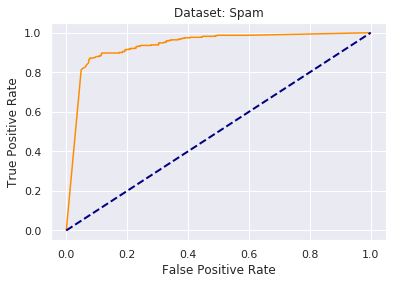

In [23]:
X_train, X_test, y_train, y_test = train_test_split(spam_x, spam_y, test_size=0.2, random_state=42)
model = GNBClassifier()
model.fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test)[:, 1])
print('Roc auc score: ' + str(roc_auc_score(y_test, model.predict(X_test)[:, 1])))
plot_roc_curve(fpr, tpr, 'Dataset: Spam')

Roc auc score: 0.99737962659679


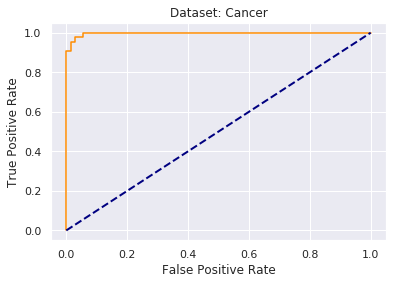

In [22]:
X_train, X_test, y_train, y_test = train_test_split(cancer_x.astype('float64'), np.array([int(y == 'M') for y in cancer_y]),
                                                    test_size=0.2, random_state=42)
model = GNBClassifier()
model.fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test)[:, 1])
print('Roc auc score: ' + str(roc_auc_score(y_test, model.predict(X_test)[:, 1])))
plot_roc_curve(fpr, tpr, 'Dataset: Cancer')

## 4)

In [24]:
smsspam_data = pd.read_csv('smsspam.csv').values
smsspam_X = smsspam_data[:, 1]
smsspam_y = smsspam_data[:, 0]

In [25]:
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /home/vladimir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
def stem_words(words):
    return [PorterStemmer().stem(word) for word in word_tokenize(words)]

class DNBClassifier:
    def fit(self, X, y):
        self.labels, self.class_prob = np.unique(y, return_counts=True)
        self.class_prob = self.class_prob / len(y)
        self.word_map, self.word_frequency = self.get_word_map_and_frequency(X, y)
        
    def predict(self, X):
        X = [stem_words(X[i]) for i in range(len(X))]
        prob = np.empty((len(X), len(self.class_prob)))
        for label in range(len(self.class_prob)):
            for i in range(len(X)):
                pdf = 1
                for j in range(len(X[i])):
                    if X[i][j] in self.word_map:
                        word_id = self.word_map[X[i][j]]
                        pdf *= (self.word_frequency[label][word_id] + 1)/ (np.sum(self.word_frequency[label]) + len(self.word_map))
                prob[i, label] = pdf * self.class_prob[label]
        for i in range(prob.shape[0]):
            if np.sum(prob[i]) != 0:
                prob[i] = prob[i] / np.sum(prob[i])
        return prob
    
    def get_word_map_and_frequency(self, texts, y):
        text_words = np.array([word for row in texts for word in stem_words(row)])
        unique_words, counts = np.unique(text_words, return_counts=True)
        unique_words = unique_words[sorted(range(len(counts)), key=lambda x: counts[x], reverse=True)]
        labels_count = np.zeros((len(self.labels), len(counts)))
        for i in range(len(self.labels)):
            label_words = np.array([word for row in texts[y == i] for word in stem_words(row)])
            for j in range(len(counts)):
                labels_count[i][j] += np.sum(label_words == unique_words[j])
        return {unique_words[i]: i for i in range(unique_words.shape[0])}, labels_count


Roc auc score: 0.9778370642099852


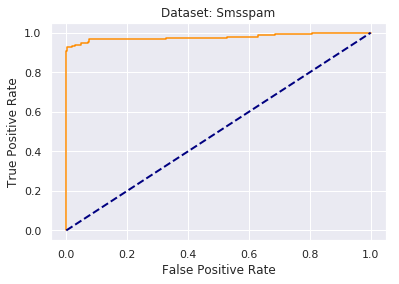

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(smsspam_X, np.array([int(y == 'spam') for y in smsspam_y]),
                                                    test_size=0.2, random_state=42)
model = DNBClassifier()
model.fit(X_train, y_train)
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test)[:, 1])
print('Roc auc score: ' + str(roc_auc_score(y_test, model.predict(X_test)[:, 1])))
plot_roc_curve(fpr, tpr, 'Dataset: Smsspam')